In [40]:

import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-whitegrid')

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn import decomposition
from sklearn import preprocessing
from functions import *

# Partie 1 : Inspection des données & Nettoyages des données

<span style="color: #00FFFF">@ Télécharger le fichier de format csv et puis le palce dans un dataframe nommé `loandown`. Les colonnes du fichier sont uniquement séparées par le caractère de tabulation `/t`. </span> 

In [41]:
loandown = pd.read_csv('fr.openfoodfacts.org.products.csv', sep='\t')

/home/ying/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,35,36,37,38,39,48) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


<span style="color: #FF00FF">  @ Nettoyez : filtrer le dataframe `loandown` avec les variables choisies selon l'annalyse nutritionnelle loyenne pour 100 g . </span>

In [42]:
data = loandown[['code','pnns_groups_1','pnns_groups_2', 'url', 'product_name', 'ingredients_text',  'countries_fr', 'image_url',
                 'energy_100g',  'fiber_100g', 'proteins_100g','fat_100g', 'saturated-fat_100g','carbohydrates_100g', 'sugars_100g', 'salt_100g', 'sodium_100g','nutrition_grade_fr', 'nutrition-score-fr_100g']]

<span style="color: #00FFFF">  </span>

In [43]:
feature_numerique=['energy_100g', 'fiber_100g', 'proteins_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g','sugars_100g', 'salt_100g','sodium_100g','nutrition-score-fr_100g']
feature_categorielle=['code', 'pnns_groups_1','pnns_groups_2','url', 'product_name', 'categories', 'additives', 'ingredients_text', 'nutrition_grade_fr', 'countries_fr', 'image_url']

<span style="color: #FF00FF">  @ Nettoyez : les doublons du dataframe `data` dans la colonne `code`. </span>

In [44]:
data.drop_duplicates(subset ="code", keep = 'first', inplace=True)

/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


<span style="color: #FF00FF">  @ Nettoyez : On s'intéresse uniquement les produits français. </span>

In [45]:
data=data.loc[data['countries_fr']=='France']

<span style="color: #00FFFF">@ Détection d'outliers : Un describe peut potentiellement nous aider dans un premier temps :
- le Nutri-Score a des valeurs suivantes pour les différentes lettres :
    + Nutri-Score A : -15 à -1
    + Nutri-Score B : 0 à 2
    + Nutri-Score C : 3 à 10
    + Nutri-Score D : 11 à 18
    + Nutri-Score E : 19 à 40 
    
 

</span>

<span style="color: #00FFFF"> @ On remplace les valeurs aberrantes de la colonne `energy_100g` par un NAN : </span>

In [46]:
data.loc[data['energy_100g']<0]=np.nan;
data.loc[data['energy_100g']>4000]=np.nan;

<span style="color: #00FFFF"> @ On remplace les valeurs aberrantes par un NAN, sauf les colonnes `energy_100g` et `nutrition-score-fr_100g` : </span>

In [47]:
def supp_aberrante_describe (feature_numerique, data):
   feature_numerique.remove('energy_100g')
   feature_numerique.remove('nutrition-score-fr_100g')
   
   for i in range(len(feature_numerique)):
       data.loc[data[feature_numerique[i]]>100]=np.nan
       data.loc[data[feature_numerique[i]]<0]=np.nan
   return data

In [48]:
data = supp_aberrante_describe(feature_numerique,data);

<span style="color: #00FFFF"> @ On remplace les valeurs aberrantes par un NAN avec la méthode interquartile: </span>

In [49]:
def supp_aberrante_interquartile (feature_numerique, data):
   
   for i in range(len(feature_numerique)):
       #On calcule Q1
       q1=data[feature_numerique[i]].quantile(q=0.25)
       #On calcule Q3
       q3=data[feature_numerique[i]].quantile(q=0.75)
       
       #On calcule l'écart interquartile (IQR)
       IQR=q3-q1
       
       #On calcule la borne inférieure à l'aide du Q1 et de l'écart interquartile
       borne_inf = q1-1.5*IQR
       
       #On calcule la borne supérieure à l'aide du Q3 et de l'écart interquartile
       borne_sup = q3 +1.5*IQR
       
       #On remplace des valeurs à l'extérieur de la borne inférieure et supérieure par un NAN.
       data.loc[data[feature_numerique[i]]>borne_sup]=np.nan
       data.loc[data[feature_numerique[i]]<borne_inf]=np.nan
      
   return data

In [50]:
data = supp_aberrante_interquartile(feature_numerique, data)

<span style="color: #00FFFF"> @ Valeurs aberrantes : Les valeurs de la colonne `saturated-fat_100g` est supérieur aux valeurs de la colonne `fat_100g` : </span>

In [51]:
data.loc[data['saturated-fat_100g']>data['fat_100g']]=np.nan
data.loc[data['sugars_100g']>data['carbohydrates_100g']]=np.nan
data.loc[data['sodium_100g']>data['salt_100g']]=np.nan

<span style="color: #00FFFF"> @ NAN : Remplacer les valeurs manquantede de la colonne `fiber_100` par `0`. On supprimer d'abord toutes les lignes qui ne contient que les Nan. </span>

In [52]:
index_with_nan = data.index[data.isnull().mean(axis=1)==1]
data.drop(index_with_nan,0, inplace=True);

/tmp/ipykernel_126/2763583042.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data.drop(index_with_nan,0, inplace=True);


In [53]:
data.loc[data['fiber_100g'].isna(),'fiber_100g']=0;
data.isna().mean();

<span style="color: #00FFFF"> @ NAN : Compléter les valeurs manquantede des colonnes `'energy_100g', 'proteins_100g','fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g'` par un `IterativeImputer`. </span>

In [54]:
imputer = IterativeImputer()
imputer.fit(data[['energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g' ]])
data[['energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g' ]]=imputer.transform(data[['energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g' ]])

/home/ying/.local/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [55]:
imputer_salt = IterativeImputer()
imputer_salt.fit(data[['salt_100g', 'sodium_100g']])
data[['salt_100g', 'sodium_100g' ]]=imputer_salt.transform(data[['salt_100g', 'sodium_100g']])

<span style="color: #00FFFF"> @ Valeurs aberrantes : Après un `IteractiveImputer`, On remplace les valeurs aberrantes par `0`, dans les colonnes `'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'salt_100g', 'sodium_100g'` : </span>

In [56]:
# Supprimer les nouveaux données négatives:
for i in ['fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'salt_100g', 'sodium_100g']:
    data=data[data[i]>0]
    data=data[data[i]<100]

<span style="color: #00FFFF"> @ NAN: On supprime les valeurs NAN, dans les colonnes `pnns_groups_1` & `nutrition_grade_fr` </span>

In [57]:
# supprimer les NAN dans la colonne `pnns_groups_1` et `nutritions_grade_fr` et `proteins_100g`
data=data.drop((data.loc[data['pnns_groups_1'].isna()]).index)
data=data.drop((data.loc[data['nutrition_grade_fr'].isna()]).index)
data=data.drop((data.loc[data['proteins_100g'].isna()]).index)
data=data.drop(data.loc[data['pnns_groups_1']=='unknown'].index)

In [58]:
# on reindexe
data = data.reset_index(drop = True)

<span style="color: #00FFFF"> @ On tranforme la lettre miniscule de la variable `nutrition_grade_fr` en majuscule. </span>

In [59]:
data['nutrition_grade_fr']=data['nutrition_grade_fr'].astype(str).str.upper() 

# Partie 2 : Analyse exploratoire des données

<span style="color: #00FFFF"> @ Analyse uni-variée: `feature_numerique`. </span>

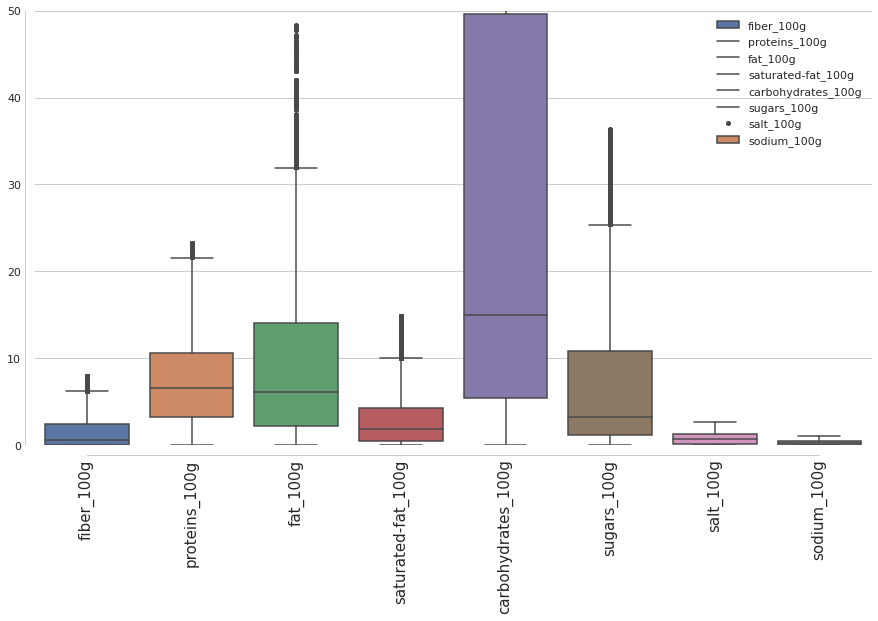

In [60]:
plt.figure(figsize=(15,8))
sns.boxplot(data=data[feature_numerique], flierprops=dict(marker='o', markersize=4),orient='v',showmeans=False)

plt.ylim(0,50)
sns.despine(offset=10, trim=True)
plt.legend(labels = feature_numerique,loc = 'upper right')

plt.xticks(rotation =90, fontsize=15)
plt.show() 

<span style="color: #00FFFF"> @ Analyse uni-varié: camember de la variable `nutrition_grade_fr`. </span>

In [61]:
sum=data['nutrition_grade_fr'].value_counts().sum()
data['nutrition_grade_fr'].value_counts()/sum

C    0.271502
D    0.225841
A    0.213787
B    0.200797
E    0.088073
Name: nutrition_grade_fr, dtype: float64

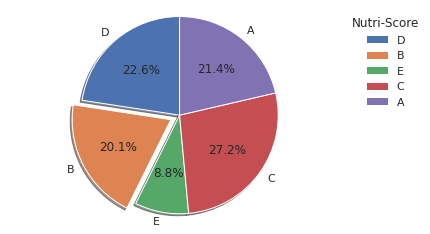

In [62]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
effectif = data['nutrition_grade_fr'].value_counts(sort = False, ascending = False) 
labels = effectif.index

explode = (0, 0.1, 0, 0,0)  # only "explode" the 2nd slice (i.e. 'Hogs')
sns.set()
fig1, ax1 = plt.subplots()
ax1.pie(effectif, explode=explode, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

#ax1.set_title("Nutrition_grade_fr")
plt.legend(labels, ncol=1, loc='upper left',title = "Nutri-Score",bbox_to_anchor = (1,1))
plt.show()

<span style="color: #00FFFF"> @ Analyse bi-variée: entre  les variables numériques `carbohydrates_100g`, `energy_100g`, `salt_100g`. </span>

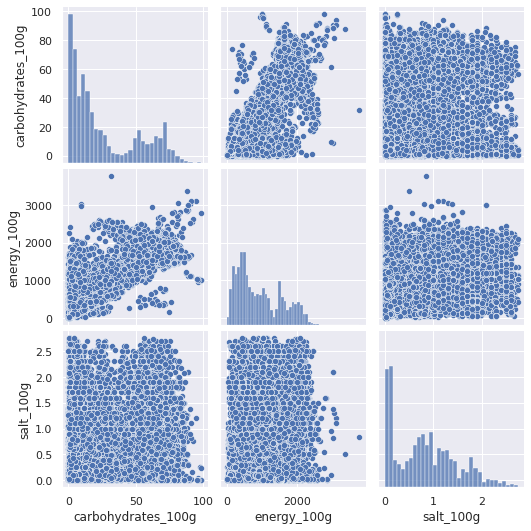

In [63]:
sns.pairplot(data, vars=["carbohydrates_100g", "energy_100g",'salt_100g'])

<span style="color: #00FFFF"> @ Analyse bi-variée: entre la variable catégorielle `nutrition_grade_fr` et les variables numériques `fat_100g` & `carbohydrates_100g`. </span>

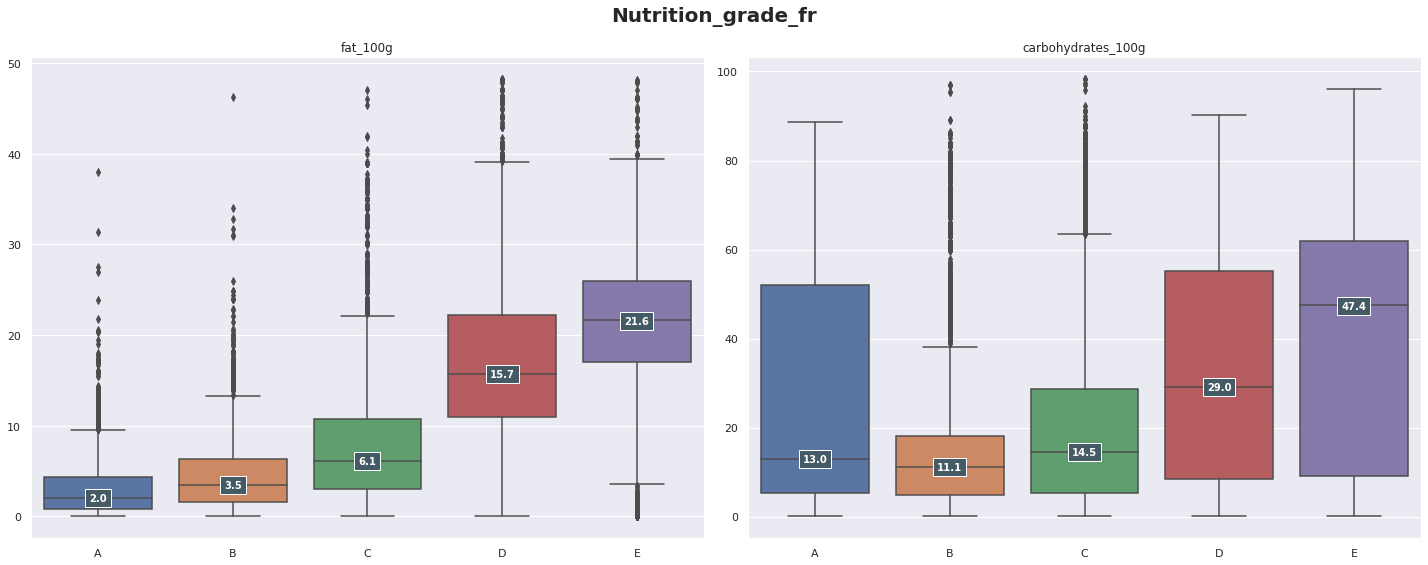

In [64]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(20,8))
fig.suptitle('Nutrition_grade_fr',fontweight ="bold",fontsize=20)

liste=['fat_100g','carbohydrates_100g']

for i in range(len(liste)):
    axes[i].set_title(liste[i])
  
    box_plot=sns.boxplot(ax=axes[i], x='nutrition_grade_fr',y=liste[i],data=data, order=['A', 'B','C','D','E'])
    ax = box_plot.axes
    lines = ax.get_lines()
    categories = ax.get_xticks()
    box_plot.set(xlabel=None)  # remove xlabel
    box_plot.set(ylabel=None)

    for cat in categories:
    # every 4th line at the interval of 6 is median line
    # 0 -> p25 1 -> p75 2 -> lower whisker 3 -> upper whisker 4 -> p50 5 -> upper extreme value
        y = round(lines[4+cat*6].get_ydata()[0],1) 

        ax.text(
            cat, 
            y, 
            f'{y}', 
            ha='center', 
            va='center', 
            fontweight='bold', 
            size=10,
            color='white',
            bbox=dict(facecolor='#445A64'))

    box_plot.figure.tight_layout()

<span style="color: #00FFFF"> @ Analyse bi-variées : ANOVA Using Statsmodels </span>

In [65]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

mod = ols('fat_100g ~ nutrition_grade_fr',data=data).fit()  # set up the ANOVA model
                
aov_table = sm.stats.anova_lm(mod, typ=2)

In [66]:
esq_sm = aov_table['sum_sq'][0]/(aov_table['sum_sq'][0]+aov_table['sum_sq'][1])
aov_table['EtaSq'] = [esq_sm, 'NaN']
print(aov_table)

                          sum_sq       df            F  PR(>F)     EtaSq
nutrition_grade_fr  7.448026e+05      4.0  3768.954221     0.0  0.425933
Residual            1.003836e+06  20319.0          NaN     NaN       NaN


<span style="color: #00FFFF"> @ Analyse bi-variée: entre deux variables catégorielles `carbohydrates_100g` et `nutrition_grade_fr`. </span>

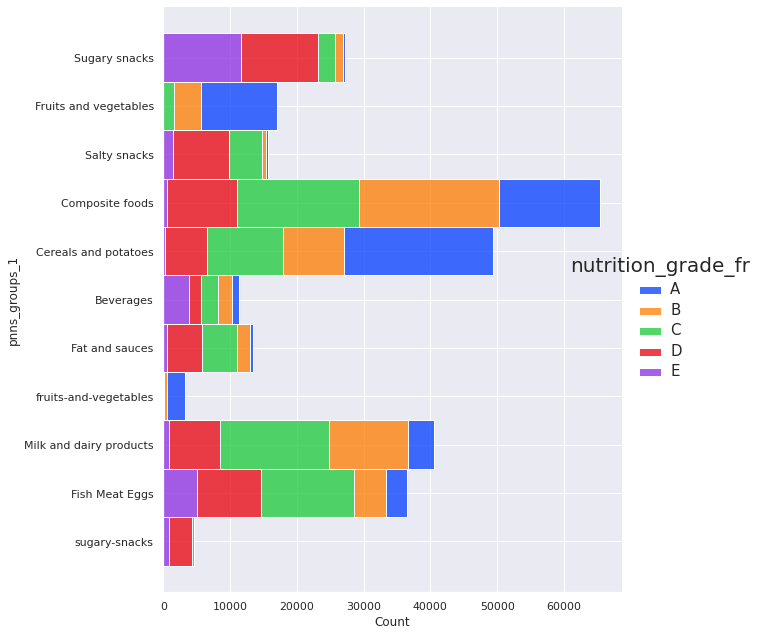

In [67]:
dis_plot=sns.displot(data, y="pnns_groups_1", hue="nutrition_grade_fr",
                     hue_order=['A', 'B','C','D','E'],
                     height=9, weights=14, multiple="stack",
                     palette=sns.color_palette('bright')[:5]
                    )
# Legend title
dis_plot.legend.get_title().set_fontsize(20)

# Legend texts
for text in dis_plot.legend.texts:
    text.set_fontsize(15)

In [68]:
data.shape

(20324, 19)

<span style="color: #00FFFF"> @ ACP: On trace `le cercle de corrélation` et `l'éboulis des valeurs propres` </span>

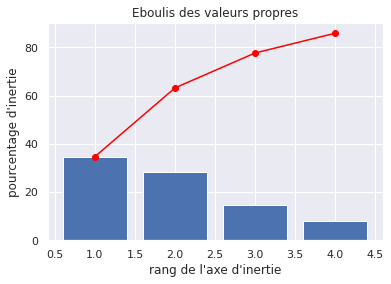

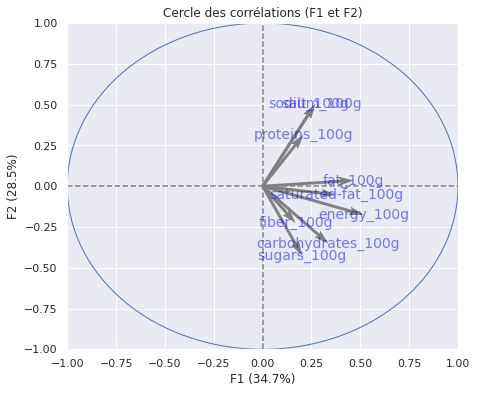

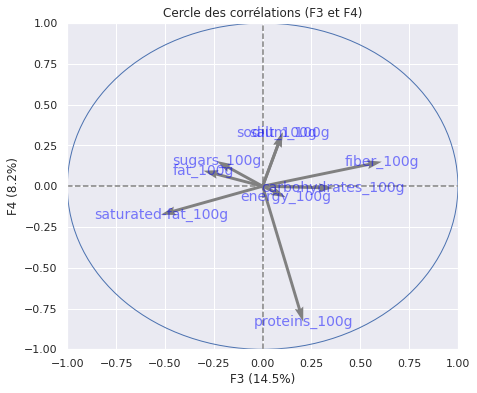

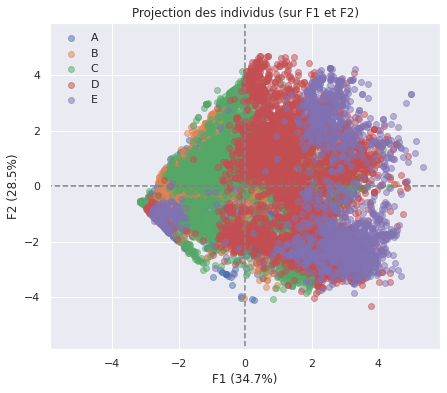

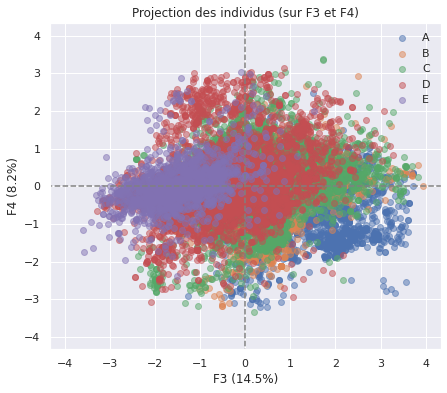

In [69]:
# choix du nombre de composantes à calculer
n_comp = 4


# selection des colonnes à prendre en compte dans l'ACP
data_pca = data[['energy_100g','fiber_100g', 'proteins_100g', 'fat_100g', 'saturated-fat_100g','carbohydrates_100g', 'sugars_100g', 'salt_100g', 'sodium_100g']]

# préparation des données pour l'ACP
data_pca = data_pca.fillna(data_pca.mean()) # Il est fréquent de remplacer les valeurs inconnues par la moyenne de la variable
X = data_pca.values
features =['energy_100g','fiber_100g', 'proteins_100g', 'fat_100g', 'saturated-fat_100g','carbohydrates_100g', 'sugars_100g', 'salt_100g', 'sodium_100g']

# Names
names = data['nutrition_grade_fr'] 

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

# Eboulis des valeurs propres
display_scree_plot(pca)

# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1),(2,3)], labels = np.array(features))

# Projection des individus
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3),(4,5)], illustrative_var = names, alpha = 0.5)

plt.show()

In [70]:
pcs

array([[ 0.51782437,  0.16918796,  0.20909286,  0.46684382,  0.3768714 ,
         0.33698754,  0.20292367,  0.26907182,  0.2690726 ],
       [-0.17520495, -0.22597746,  0.31503923,  0.03582521, -0.05353653,
        -0.35142464, -0.42670812,  0.50460898,  0.50460753],
       [ 0.11890925,  0.61011613,  0.20798306, -0.30292008, -0.52084291,
         0.36223446, -0.23494273,  0.10225449,  0.10225536],
       [-0.06835867,  0.15032775, -0.83131756,  0.09507063, -0.17476166,
        -0.01126762,  0.15472008,  0.33014525,  0.33014931]])

# Partie 3 : Application

<span style="color: #00FFFF"> @ On crée une nouvelle colonne `for_kids`, on met un `Y` pour les produits qui complissent les conditions des produits d'enfants, sinon on met un `N` </span>

In [71]:
produit_enfant = data

produit_enfant = produit_enfant.loc[produit_enfant['energy_100g']<221]
produit_enfant = produit_enfant.loc[produit_enfant['carbohydrates_100g']<7.6]
produit_enfant = produit_enfant.loc[produit_enfant['salt_100g']<0.7]
produit_enfant = produit_enfant.loc[produit_enfant['fat_100g']<1.2]

In [72]:
data["for_kids"]='N'

for i in produit_enfant.index:  
    data['for_kids'][i]='Y'

/tmp/ipykernel_126/695591658.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['for_kids'][i]='Y'


In [73]:
data.iloc[117,:]; # test

<span style="color: #00FFFF"> note </span>

In [74]:
produit_enfant['pnns_groups_1'].value_counts()

Fruits and vegetables      291
Beverages                  144
Milk and dairy products    118
fruits-and-vegetables       97
Composite foods             48
Fat and sauces              20
Cereals and potatoes        18
Fish Meat Eggs               1
Name: pnns_groups_1, dtype: int64

<span style="color: #00FFFF"> @ Application : Proposer les produits simillaires adaptés aux enfants autour un an: </span>

In [75]:
def products_similaires (product):
    print("Nom de product : " + product['product_name']);     print (" ")
      
    
    if product['for_kids']=='Y':
        print("Ce product convient aux enfants autour un an !")
    else:
        print('Pour un enfant, des matières suivantes sont surdosées : ')
        if product['salt_100g']>0.7 :  salt = product['salt_100g'];       print('sel: 'f"{salt} g")
        if product['fat_100g']>1.2 :   fat = product['fat_100g'];         print('Fat: 'f"{fat} g")
        if product['carbohydrates_100g']>7.6 : carbohydrates = product['carbohydrates_100g'];    print('Carbohydrates: 'f"{carbohydrates} g")
        if product['energy_100g']>221 : energy = product['energy_100g'];   print('Energy: 'f"{energy} g")
    
    print("")
    
      
    product_categorie  = product['pnns_groups_1']
    
    for i in produit_enfant['pnns_groups_1'].unique().tolist():
        
        if product_categorie ==i:
            print("Vous pouvez regarder les products dans la même catégorie : " f"{i} :")
            pdct_s = produit_enfant.loc[produit_enfant['pnns_groups_1']==i]
            if pdct_s.shape[0]>=5:
                print(pdct_s.sample(n=5, ignore_index=True).product_name)
            else:
                print(pdct_s.sample(n=pdct_s.shape[0], ignore_index=True).product_name)
        if product_categorie=='Fish Meat Eggs': print(" ")

In [76]:
index_aleatroie = np.random.randint(data.shape[0])
produit_aleatroie = data.iloc[index_aleatroie]

products_similaires (produit_aleatroie)

Nom de product : Goûters fourrés parfum chocolat
 
Pour un enfant, des matières suivantes sont surdosées : 
Fat: 16.5 g
Carbohydrates: 73.0 g
Energy: 1989.0 g

